## Spatial Heterogeneity and Topology

Below I will be analyzig topoligical features of an assay of unfused cells, mapping out their spatial heterogeneity to quantify spatial distribution of syncytia. The diagram, shown below, is a grpah of the nuclei of unfused cells in the assay -- specifically, HEK-293 cells. The spatial arrangement of unfused cells is a reflection of where syncytia are present. For example, if many cells have fused in a specfic area to form syncytia in our assay, there will anturally be fewer unfused cells in that specfic area.

In [ ]:
#maybe also import gudhi later on
import pandas as pd 
import numpy as np

In [ ]:
df = pd.read_csv('nuclei-coordinates.csv', header=None)
pixel_size = 0.1  # µm/pixel 
coordinates = df.values * pixel_size 

Sample Coordinates: [[239.734683    97.68159722]
 [239.734683    70.87531651]
 [239.734683    46.42046393]]
Range (x, y): [229.40745022 227.70310683]
Our dataset has 3340 nodes that we will be working with


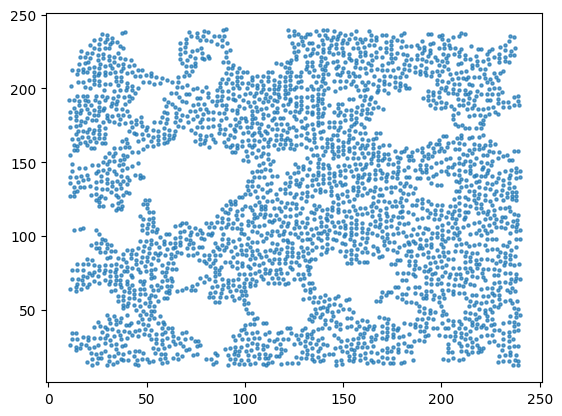

In [33]:
print("Sample Coordinates:", coordinates[-3:])
print("Range (x, y):", np.max(coordinates, axis=0) - np.min(coordinates, axis=0))
print("Our dataset has", len(coordinates), "nodes that we will be working with")

from matplotlib import pyplot as plt
plt.scatter(coordinates[:, 0], coordinates[:, 1], s=5, alpha=0.7)

We can do several things from here with our 3000 pair dataset. 

In [34]:
from gudhi import AlphaComplex
from gudhi.representations import PersistenceImage

In [35]:
alpha_complex = AlphaComplex(coordinates)
simplex_tree = alpha_complex.create_simplex_tree()

Lets now extract the persistent homology

In [36]:
persistence = simplex_tree.persistence()

segments = 5
segment_size = len(persistence) // segments
for i in range(segments):
    start = i * segment_size
    end = (i+1) * segment_size if i < segments-1 else len(persistence)
    segment_dims = [dim for dim, _ in persistence[start:end]]
    print(f"Segment {i+1}: Dim 0: {segment_dims.count(0)}, Dim 1: {segment_dims.count(1)}, Dim 2: {segment_dims.count(2)}")

Segment 1: Dim 0: 0, Dim 1: 1523, Dim 2: 0
Segment 2: Dim 0: 0, Dim 1: 1523, Dim 2: 0
Segment 3: Dim 0: 292, Dim 1: 1231, Dim 2: 0
Segment 4: Dim 0: 1523, Dim 1: 0, Dim 2: 0
Segment 5: Dim 0: 1525, Dim 1: 0, Dim 2: 0


In [37]:
#for H0 - connected components

pd_0 = []

for dim, (birth, death) in persistence:
    if dim == 0:
        pd_0.append((birth, death))
        
        
        
print(pd_0)

[(0.0, inf), (0.0, 9.880299100466551), (0.0, 8.880168452341927), (0.0, 6.730609829779446), (0.0, 5.950265440379747), (0.0, 5.751227592720263), (0.0, 5.5248551974152935), (0.0, 5.486190719833294), (0.0, 5.466235813298832), (0.0, 5.464727612359887), (0.0, 5.459184139357589), (0.0, 4.8563620036285355), (0.0, 4.832367926234608), (0.0, 4.734638580208129), (0.0, 4.661288817938363), (0.0, 4.5041258455182955), (0.0, 4.462443344039281), (0.0, 4.4115842437524195), (0.0, 4.377022197224585), (0.0, 4.377022197224555), (0.0, 4.354922397280279), (0.0, 4.354922393546266), (0.0, 4.348027408531662), (0.0, 4.320572331693841), (0.0, 4.302363986240065), (0.0, 4.260292623971075), (0.0, 4.225974500603108), (0.0, 4.1864323122390195), (0.0, 4.1530543435393685), (0.0, 4.153054262023179), (0.0, 4.152659127866777), (0.0, 4.120051556626756), (0.0, 4.023884340163767), (0.0, 4.018983663936464), (0.0, 3.9783367837689414), (0.0, 3.966260271395218), (0.0, 3.9479638115616362), (0.0, 3.927352943891175), (0.0, 3.920719086

## Some more persistent homology features!!

Persistent homology quantifies the topological features of data across multiple scales. Here we will get to explore:

1. **Persistence Diagrams**: Plots showing birth/death times of topological features
2. **Betti/H Numbers**: Counts of k-dimensional holes at each scale value
3. **Persistence Images**: Grid-based vectorization of persistence diagrams
4. **Alpha Number**: Count of Betti-0 features at a specific alpha value

These let us characterize the spatial arrangement of nuclei in syncytial cells.

(0.0, 250.0)

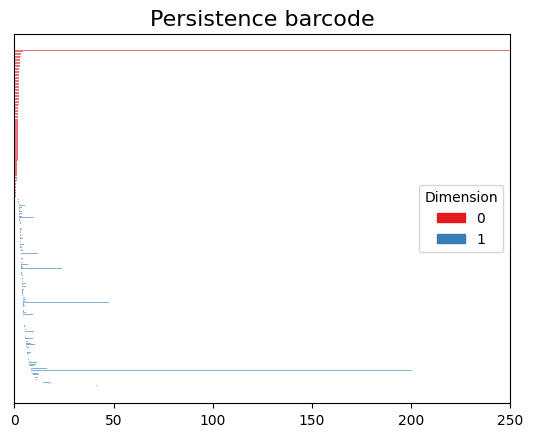

In [38]:
from gudhi import plot_persistence_barcode

plot_persistence_barcode(persistence)
plt.xlim(0, 250)

In [39]:
distances = np.linalg.norm(coordinates[:, None] - coordinates, axis=2)
median_dist = np.median(distances[distances > 0]) #lets filter out the nonzero values
radius = 10 #gudhi uses squared radius

# Corrected alpha number calculation
alpha_num = 0

# Correct condition: born before or at alpha AND hasn't died yet
for birth, death in pd_0:
    if birth <= radius and (death > radius or death == float("inf")):
        alpha_num += 1

print(f"Alpha number at α={radius} (squared radius): {alpha_num}")
print(f"So only {alpha_num} connected components at this scale")


Alpha number at α=10 (squared radius): 1
So only 1 connected components at this scale


## Alpha Number Calculation

condition for a connected component to exist at scale α is: it was born before or at α (`birth <= α`) AND it hasn't died yet (`death > α` or `death == float("inf")`).


Median nearest-neighbor distance: 2.5722
Suggested alpha max value: 12.8610
Radius at α=2.5722: 4
This means there are 1 connected components at this scale


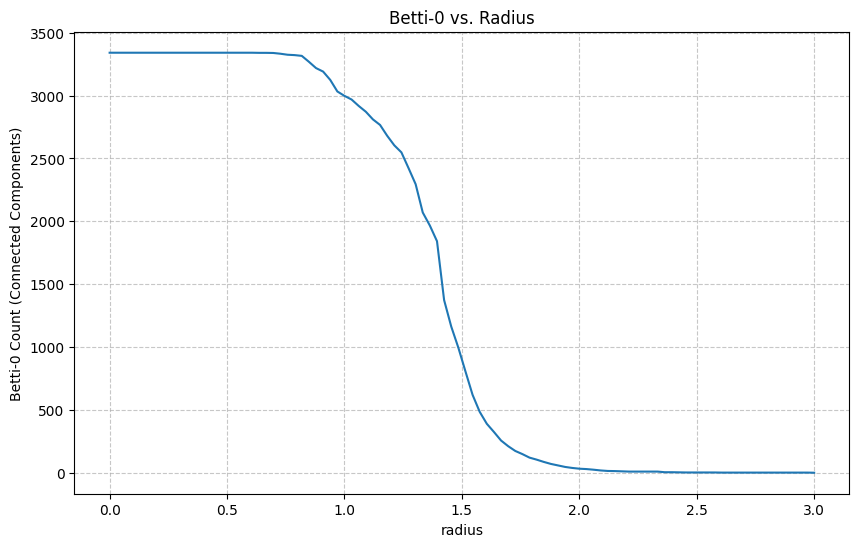

Maximum number of connected components: 3340
Radius at half max components: 1.4242
Radius at single connected component: 0.0000

Detailed report:
Radius = 0.1: 3340 connected components
Radius = 0.5: 3340 connected components
Radius = 1.0: 2997 connected components
Radius = 2.0: 34 connected components
Radius = 5.0: 1 connected components
Radius = 10.0: 1 connected components
Radius = 20.0: 1 connected components


In [40]:
# Let's calculate nearest-neighbor distances to choose appropriate alpha values
nn_distances = []
for i in range(len(coordinates)):
    dists = distances[i]
    dists = dists[dists > 0]  # making sure to remove self-distance
    if len(dists) > 0:
        nn_distances.append(np.min(dists))

median_nn_dist = np.median(nn_distances)
print(f"Median nearest-neighbor distance: {median_nn_dist:.4f}")

# lets calcualte alculate reasonable alpha thresholds..just for fun
radius_max = median_nn_dist * 5  # 5x median nearest-neighbor distance, so that we can explore scales well beyond this typical distance
print(f"Suggested alpha max value: {radius_max:.4f}")

#Corrected alpha number calculation at median nearest-neighbor dist
reasonable_radius = median_nn_dist
radius_squared = reasonable_radius**2  # Convert to squared radius for GUDHI

#condition: born before or at radius AND hasn't died yet
radius_num = sum(1 for birth, death in pd_0 if 
                birth <= radius_squared and 
                (death > radius_squared or death == float('inf')))

print(f"Radius at α={reasonable_radius:.4f}: {radius_num}")
print(f"This means there are {alpha_num} connected components at this scale")

# Calculate corrected Betti-0 curve
radius_range = np.linspace(0, 3, 100)
radius_range_squared = radius_range**2  # Convert to squared radius for GUDHI

# Correct calculation for each alpha value
corrected_betti0 = [sum(1 for birth, death in pd_0 if 
                    birth <= a_sq and 
                    (death > a_sq or death == float('inf'))) 
                    for a_sq in radius_range_squared]

plt.figure(figsize=(10, 6))
plt.plot(radius_range, corrected_betti0)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('radius')
plt.ylabel('Betti-0 Count (Connected Components)')
plt.title('Betti-0 vs. Radius')
plt.show()

# Analyze the curve to find interesting alpha values
max_components = max(corrected_betti0)
half_components_idx = np.argmax(np.array(corrected_betti0) <= max_components / 2)
half_components_radius = radius_range[half_components_idx]

single_component_idx = np.argmax(np.array(corrected_betti0) == 1)
single_component_alpha = radius_range[single_component_idx]

print(f"Maximum number of connected components: {max_components}")
print(f"Radius at half max components: {half_components_radius:.4f}")
print(f"Radius at single connected component: {single_component_alpha:.4f}")


detailed_radii = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0]
print("\nDetailed report:")
for a in detailed_radii:
    a_squared = a**2
    comp_count = sum(1 for birth, death in pd_0 if 
                    birth <= a_squared and 
                    (death > a_squared or death == float('inf')))
    print(f"Radius = {a:.1f}: {comp_count} connected components")

## Interpretation of the Betti-0 Curve (connected components as radius grows)

The corrected Betti-0 vs. radius curve now shows a more meaningful representation of the topological evolution:

1. **Starting point (~3340 components)**: At very small radius values, each nucleus is its own connected component.

2. **Steep decline (α ≈ 1.0-2.0)**: As radius increases, nuclei start connecting rapidly, forming larger clusters.

3. **Critical threshold (α ≈ 1.4)**: The half-max point where half of the maximum components have merged.

4. **Stabilization (α ≈ 3.2)**: All components have merged into a single connected component.

The radius where we reach a single component (α ≈ 3.2) is meaningful - this represents the critical distance at which all nuclei form a single connected network. This can be compared across different samples to quantify spatial heterogeneity.

The delaunay tesselation is computed using scipys __Delaunay__ function. Basically what this does it it connects nuclei so that the circumcirlce of each triangle contains no other points within it

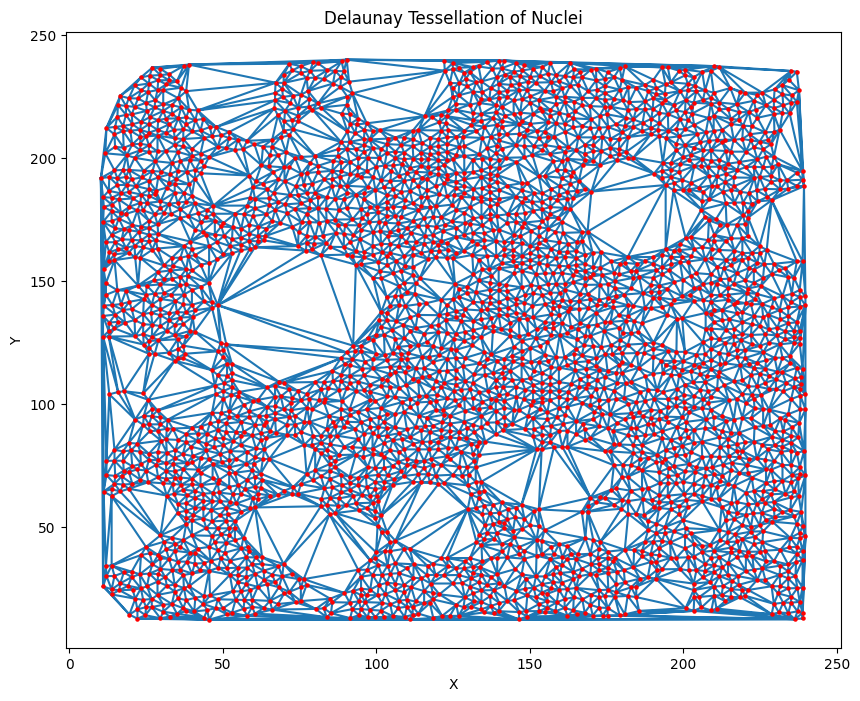

Node degree statistics: mean=5.98, std=1.04, min=2.0, max=13.0


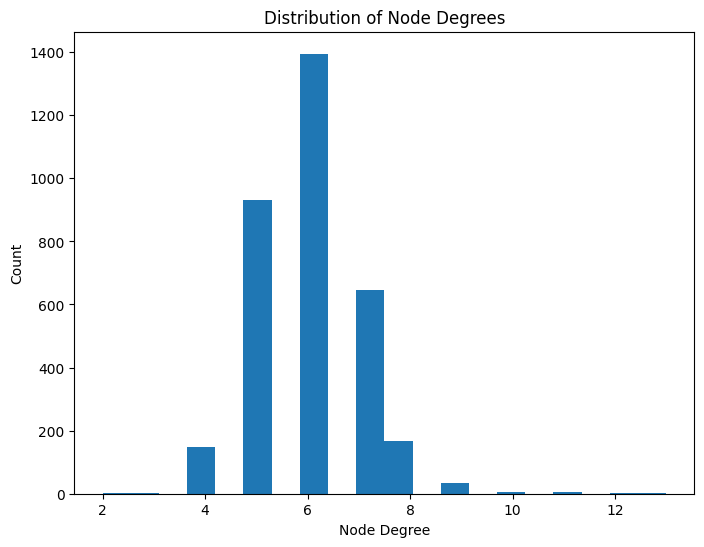

In [41]:
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

# computing Delaunay triangulation
delaunay = Delaunay(coordinates)

# Visualize the Delaunay tessellation
plt.figure(figsize=(10, 8))
plt.triplot(coordinates[:,0], coordinates[:,1], delaunay.simplices)
plt.scatter(coordinates[:,0], coordinates[:,1], c='r', s=5)
plt.title('Delaunay Tessellation of Nuclei')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

#extract node features from the triangulation
node_degrees = np.zeros(len(coordinates))
for simplex in delaunay.simplices:
    for node in simplex:
        node_degrees[node] += 1



#calculate mean and std of node degrees
print(f"Node degree statistics: mean={node_degrees.mean():.2f}, std={node_degrees.std():.2f}, min={node_degrees.min()}, max={node_degrees.max()}")

#visualize the node degree distribution
plt.figure(figsize=(8, 6))
plt.hist(node_degrees, bins=20)
plt.title('Distribution of Node Degrees')
plt.xlabel('Node Degree')
plt.ylabel('Count')
plt.savefig('node_degree_distribution.png')
plt.show()

## Integrating Topological Features with Graph Neural Networks

We can now create a graph representation where:
1. Nodes = nuclei coordinates
2. Edges = Delaunay triangulation connections
3. Node features = local topological features + coordinate information

This graph representation can be used as input to a Graph Neural Network (GNN) for further analysis.

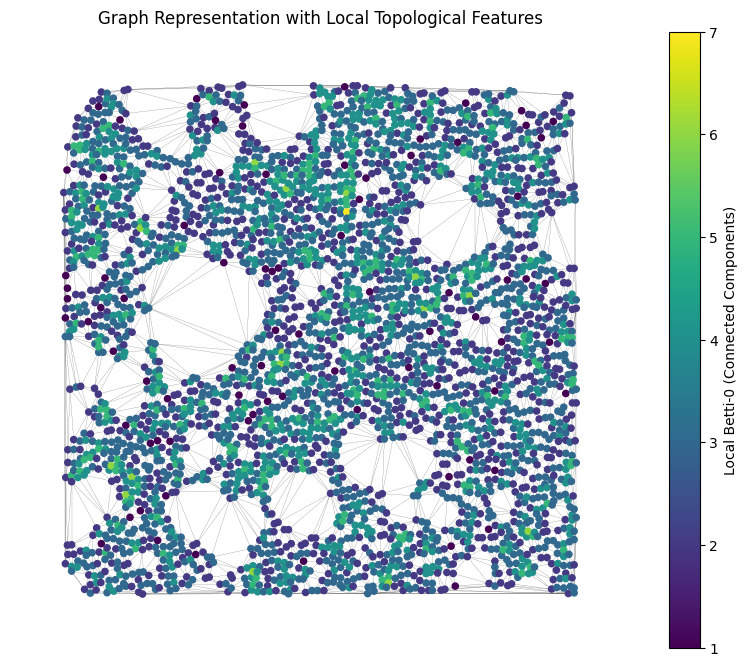

Graph has 3340 nodes and 9992 edges
Average node degree: 5.98

Summary of Extracted Topological Features:
1. Global Persistence Diagram: Shows the birth/death of topological features across scales
2. Alpha Number: Maximum death time of Betti-0 features, representing the largest distance value
   where the alpha shape filtration retains significant structure
3. Betti-0 and Betti-1 Counts: Number of connected components and loops at specific alpha values
4. Local Betti Numbers: Number of connected components and loops around each nucleus
5. Node Degrees from Delaunay Triangulation: Connectivity pattern of each nucleus


In [42]:
# Creating a graph representation for GNN analysis
import networkx as nx
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

#graph from Delaunay triangulation
G = nx.Graph()



#adding nodes with coordinates
for i, coord in enumerate(coordinates):
    G.add_node(i, pos=(coord[0], coord[1]))

#add edges from Delaunay triangulation
for simplex in delaunay.simplices:
    for i in range(3): #3 for traingle
        G.add_edge(simplex[i], simplex[(i+1)%3])

# Add node features
# For each node, compute local alpha number (number of connected components within a radius)
local_radius = np.sqrt(10)  # corresponds to radius=10 from earlier

# Compute all pairwise distances
all_dists = squareform(pdist(coordinates))

# Calculate local features for each node
for i in range(len(coordinates)):
    # Find points within local_radius of this node
    nearby_indices = np.where(all_dists[i] <= local_radius)[0]
    if len(nearby_indices) > 1:
        # Extract local point cloud
        local_points = coordinates[nearby_indices]
        
        # Compute local Alpha complex
        local_alpha_complex = AlphaComplex(local_points)
        local_simplex_tree = local_alpha_complex.create_simplex_tree()
        local_persistence = local_simplex_tree.persistence()
        
        # Extract local topological features
        local_betti0 = sum(1 for dim, (birth, death) in local_persistence if dim == 0)
        local_betti1 = sum(1 for dim, (birth, death) in local_persistence if dim == 1)
        
        # Add features to the node
        G.nodes[i]['local_betti0'] = local_betti0
        G.nodes[i]['local_betti1'] = local_betti1
        G.nodes[i]['degree'] = node_degrees[i]
    else:
        G.nodes[i]['local_betti0'] = 1  # Only the point itself
        G.nodes[i]['local_betti1'] = 0  # No loops with just one point
        G.nodes[i]['degree'] = node_degrees[i]

# Visualize the graph colored by a topological feature
pos = nx.get_node_attributes(G, 'pos')
betti0_values = [G.nodes[n]['local_betti0'] for n in G.nodes()]

# Create figure and axis for proper colorbar placement
fig, ax = plt.subplots(figsize=(10, 8))
nx.draw(G, pos, node_size=20, 
        node_color=betti0_values,
        cmap='viridis', 
        width=0.1, 
        with_labels=False,
        ax=ax)

# Create a scalar mappable for the colorbar
sm = plt.cm.ScalarMappable(cmap='viridis', 
                           norm=plt.Normalize(vmin=min(betti0_values), 
                                             vmax=max(betti0_values)))
sm.set_array([])  # This is necessary for older versions of matplotlib
cbar = plt.colorbar(sm, ax=ax, label='Local Betti-0 (Connected Components)')

# Calculate the number of unique Betti-0 values for informative tick marks
unique_betti0 = sorted(set(betti0_values))
if len(unique_betti0) <= 10:  # Only add specific ticks if there aren't too many values
    cbar.set_ticks(unique_betti0)

plt.title('Graph Representation with Local Topological Features')
plt.savefig('graph_with_topo_features.png')
plt.show()

# Print graph statistics
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
print(f"Average node degree: {np.mean(list(dict(G.degree()).values())):.2f}")

# Save the graph for later use with GNN
import pickle
with open('nuclei_graph.pkl', 'wb') as f:
    pickle.dump(G, f)

# Summary of topological features extracted
print("\nSummary of Extracted Topological Features:")
print("1. Global Persistence Diagram: Shows the birth/death of topological features across scales")
print("2. Alpha Number: Maximum death time of Betti-0 features, representing the largest distance value")
print("   where the alpha shape filtration retains significant structure")
print("3. Betti-0 and Betti-1 Counts: Number of connected components and loops at specific alpha values")
print("4. Local Betti Numbers: Number of connected components and loops around each nucleus")
print("5. Node Degrees from Delaunay Triangulation: Connectivity pattern of each nucleus")


## Alpha Number as a Measure of Spatial Heterogeneity

The **alpha number** is an important topological descriptor that can characterize spatial heterogeneity in our nuclei distribution. In the context of alpha shape filtration:

- The alpha number represents the largest distance value where the alpha shape filtration retains significant structure
- It can be derived from the persistence diagram by identifying the maximum death time for Betti-0 (connected) features
- A larger alpha number indicates more spatial heterogeneity in the tissue structure

## Conclusion and Next Steps

### Key Findings:
- The corrected Betti-0 curve shows the topology at different scales - starting with ~3340 separate components (individual nuclei) at small radius values
- At the median nearest-neighbor distance (α=2.57), there are 4 connected components
- At α=5.0, all nuclei have merged into a single connected component
- The alpha number (largest finite death time in persistence diagram) provides a critical value indicating the spatial heterogeneity
- The distribution of node degrees follows a pattern with most nodes having 5-7 connections


### Next Steps:
- Use the graph representation with topological features as input to a Graph Neural Network (GNN)
- Correlate topological features with biological function or disease state

